# **Preprocessing of the VisDrone2019-DET Dataset**

The [VisDrone2019](https://github.com/VisDrone/VisDrone-Dataset) dataset contains 288 video clips comprising a total of 261,908 frames and 10,209 images in challenging scenes, captured by drones in 14 different cities across China. These images were taken in various scenarios and under diverse weather and lighting conditions. In this notebook, the **VisDrone2019-DET** dataset, specifically designed for object detection in images, will be preprocessed. This dataset includes 12 categories and is divided into 6,471 images for training, 548 for validation, 1,580 for the test-challenge (without annotations), and 1,610 for the test-dev.

## **Imports**

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
from google.colab import drive
from glob import glob
from tqdm.auto import tqdm
import pandas as pd
import shutil
import os

In [ ]:
# Mount Google Drive in Colab
drive.mount("/content/drive")

Mounted at /content/drive


## **Parameters**

The training, validation, and test-dev datasets are downloaded from the [official GitHub repository](https://github.com/VisDrone/VisDrone-Dataset?tab=readme-ov-file#task-1-object-detection-in-images) and uploaded to my personal Google Drive, where they are stored in the ``Raw_VisDrone2019`` folder.

In [ ]:
raw_dataset_path = "/content/drive/MyDrive/Raw_VisDrone2019"
dataset_path = os.path.join(os.getcwd(), "VisDrone2019")
zip_data_path = "/content/drive/MyDrive/Datasets/VisDrone2019.zip"

os.makedirs(dataset_path, exist_ok=True)

## **Unzip the Datasets**

In [ ]:
!unzip -q {os.path.join(raw_dataset_path, "VisDrone2019-DET-train.zip")}
!unzip -q {os.path.join(raw_dataset_path, "VisDrone2019-DET-val.zip")}
!unzip -q {os.path.join(raw_dataset_path, "VisDrone2019-DET-test-dev.zip")}

## **Preprocess the Dataset**

The dataset classes are obtained from the following [link](https://github.com/VisDrone/VisDrone2018-DET-toolkit), where there are originally 12 categories. However, in most cases, the ``ignored regions`` and ``others`` classes are excluded when building object detection models, as they are irrelevant to the models. Therefore, these classes will also be excluded in this case.

**Original classes:**
```
class_names = [
    "ignored regions", "pedestrian", "people", "bicycle", "car", "van",
    "truck", "tricycle", "awning tricycle", "bus", "motor", "others"
]
```

In [ ]:
# Create a list of the class names
class_names = [
    "pedestrian", "people", "bicycle", "car", "van",
    "truck", "tricycle", "awning tricycle", "bus", "motor"
]

num_classes = len(class_names)
print(num_classes)
print(class_names)

10
['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning tricycle', 'bus', 'motor']


In [ ]:
# Find the paths of the dataset images and annotations
train_images = sorted(glob("VisDrone2019-DET-train/images/*jpg"))
train_annotations = sorted(glob("VisDrone2019-DET-train/annotations/*txt"))

val_images = sorted(glob("VisDrone2019-DET-val/images/*jpg"))
val_annotations = sorted(glob("VisDrone2019-DET-val/annotations/*txt"))

test_images = sorted(glob("images/*jpg"))
test_annotations = sorted(glob("annotations/*txt"))

print(len(train_images), len(train_annotations))
print(len(val_images), len(val_annotations))
print(len(test_images), len(test_annotations))

6471 6471
548 548
1610 1610


In [ ]:
# Function to save the images and labels
def save_dataset(images, annotations, name="train"):
  data_path = os.path.join(dataset_path, name)
  images_path = os.path.join(data_path, "images")
  labels_path = os.path.join(data_path, "labels")

  os.makedirs(data_path, exist_ok=True)
  os.makedirs(images_path, exist_ok=True)
  os.makedirs(labels_path, exist_ok=True)

  for img_path, anno_path in tqdm(zip(images, annotations), total=len(images)):
    #Load the annotations
    annotation = np.loadtxt(anno_path, delimiter=",", usecols=np.arange(6))
    annotation = annotation[None, :] if annotation.ndim == 1 else annotation

    # Obtain the image dimensions
    shape = np.array(Image.open(img_path)).shape
    width_img, height_img = shape[1], shape[0]

    # Extract the ID from the annotation path name
    id = anno_path.split("/")[-1].split(".")[0]

    # Initialize the label variable with an empty set to avoid duplicate rows
    label = set()
    for row in annotation:
      # Extract the class ID
      cls = int(row[5])

      # Discard the 'ignored regions' and 'others' classes
      if (cls != 0) and (cls != 11):
        # Adjust the class ID
        cls -= 1

        # Extract the coordinates of the bounding boxes
        box = row[:4]
        xmin, ymin, width, height = tuple(box)

        # Normalize the coordinates to the YOLO format
        x_center = (xmin + (width / 2)) / width_img
        y_center = (ymin + (height / 2)) / height_img
        width /= width_img
        height /= height_img

        label.add((cls, x_center, y_center, width, height))

    # Discard the empty annotations
    if len(label) > 0:
      # Save the image
      shutil.copy(img_path, os.path.join(images_path, f"{id}.jpg"))

      # Save the label
      # It is more versatile than np.savetxt as it allows saving a variable number of decimals
      with open(os.path.join(labels_path, f"{id}.txt"), "w") as f:
        for row in label:
          f.write(f"{' '.join([str(e) for e in row])}\n")

In [ ]:
save_dataset(train_images, train_annotations)
save_dataset(val_images, val_annotations, name="val")
save_dataset(test_images, test_annotations, name="test")

  0%|          | 0/6471 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/1610 [00:00<?, ?it/s]

In [ ]:
print(
    len(os.listdir(os.path.join(dataset_path, "train/images"))),
    len(os.listdir(os.path.join(dataset_path, "train/labels")))
)

print(
    len(os.listdir(os.path.join(dataset_path, "val/images"))),
    len(os.listdir(os.path.join(dataset_path, "val/labels")))
)

print(
    len(os.listdir(os.path.join(dataset_path, "test/images"))),
    len(os.listdir(os.path.join(dataset_path, "test/labels")))
)

6471 6471
548 548
1610 1610


It can be observed that there were no empty annotations, as the number of images and annotations remains the same before and after preprocessing.

In [ ]:
# Create the YAML files with the dataset metadata

# To evaluate the validation dataset
with open(os.path.join(dataset_path, "data_val.yaml"), "w") as f:
  f.write(f"""
  path: VisDrone2019
  train: train/images
  val: val/images
  test: test/images

  nc: {num_classes}
  names: {class_names}
  """)

# To evaluate the test dataset
with open(os.path.join(dataset_path, "data_test.yaml"), "w") as f:
  f.write(f"""
  path: VisDrone2019
  train: train/images
  val: test/images
  test: val/images

  nc: {num_classes}
  names: {class_names}
  """)

In [ ]:
# Compress the dataset into a zip file and save it
!zip -r $zip_data_path VisDrone2019 -q

## **Visualization Example**

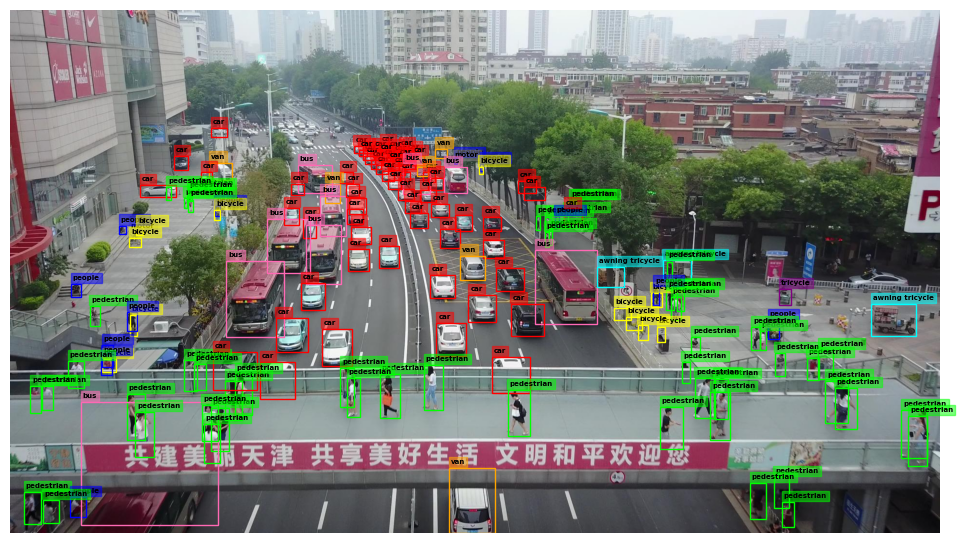

In [ ]:
class_colors = [
    "#00FF00", "#0000FF", "#FFFF00", "#FF0000", "#FFA500",
    "#8B4513", "#800080", "#00FFFF", "#FF69B4",  "#808080"
]

fig, ax = plt.subplots(1, figsize=(12, 10))

image = Image.open("/content/VisDrone2019/train/images/0000142_00858_d_0000027.jpg")
image = np.array(image)
shape = image.shape
ax.imshow(image)

annotation = np.loadtxt("/content/VisDrone2019/train/labels/0000142_00858_d_0000027.txt")
annotation = annotation[None, :] if annotation.ndim == 1 else annotation
classes = annotation[:, 0]
boxes = annotation[:, 1:]

for i in range(len(boxes)):
  box = boxes[i]
  cls = classes[i].astype(np.int32)

  x_center, y_center, width, height = tuple(box)
  xmin = (x_center - width / 2) * shape[1]
  ymin = (y_center - height / 2) * shape[0]
  xmax = (x_center + width / 2) * shape[1]
  ymax = (y_center + height / 2) * shape[0]

  rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor=class_colors[cls], facecolor="none")
  ax.add_patch(rect)

  ax.text(
      x=xmin+shape[1]*0.002, y=ymin-shape[0]*0.006, s=f"{class_names[cls]}",
      color="black", fontsize=5, fontweight="bold", ha="left", va="bottom",
      bbox={"boxstyle":"square", "facecolor": class_colors[cls], "edgecolor": class_colors[cls], "alpha":0.5}
  )

ax.axis("off");

## **Exploratory Data Analysis (EDA)**

In [ ]:
# Function to extract instance counts per class
def count_instances(path_data):
  dic_classes = {name: 0 for name in class_names}
  labels = glob(os.path.join(path_data, "labels/*.txt"))

  for label in tqdm(labels):
    ids = np.loadtxt(label)
    ids = ids[None, :][:, 0] if ids.ndim == 1 else ids[:, 0]
    names = np.array(class_names)[ids.astype(np.int32)]

    for name in names:
      dic_classes[name] += 1

  df = pd.DataFrame(list(dic_classes.items()), columns=["Class", "Count"])
  return df

In [ ]:
num_train_instances = count_instances(os.path.join(dataset_path, "train"))
num_val_instances = count_instances(os.path.join(dataset_path, "val"))
num_test_instances = count_instances(os.path.join(dataset_path, "test"))

  0%|          | 0/6471 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/1610 [00:00<?, ?it/s]

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.8 MB/s eta 0:00:00


In [ ]:
# Function to plot a barplot of class counts
def plot_counts(num_instances, split="training", renderer=None):
  num_instances = num_instances.sort_values(by="Count")
  fig = px.bar(
      num_instances, x="Count", y="Class", title="Counts of Classes",
      text="Count", color="Count",
      color_continuous_scale=[(0, "#D80000"), (0.5, "lightblue"), (1, "#003299")]
  )

  fig.update_layout(
      title=dict(text=f"Class Count in the {split.capitalize()} Set", font=dict(size=16, weight="bold"), x=0.5),
      xaxis_title=dict(text="Frequency", font=dict(size=12, weight="bold")),
      yaxis_title=dict(text="Class", font=dict(size=12, weight="bold")),
      height=600,
      width=1200
  )
  fig.show(renderer=renderer)

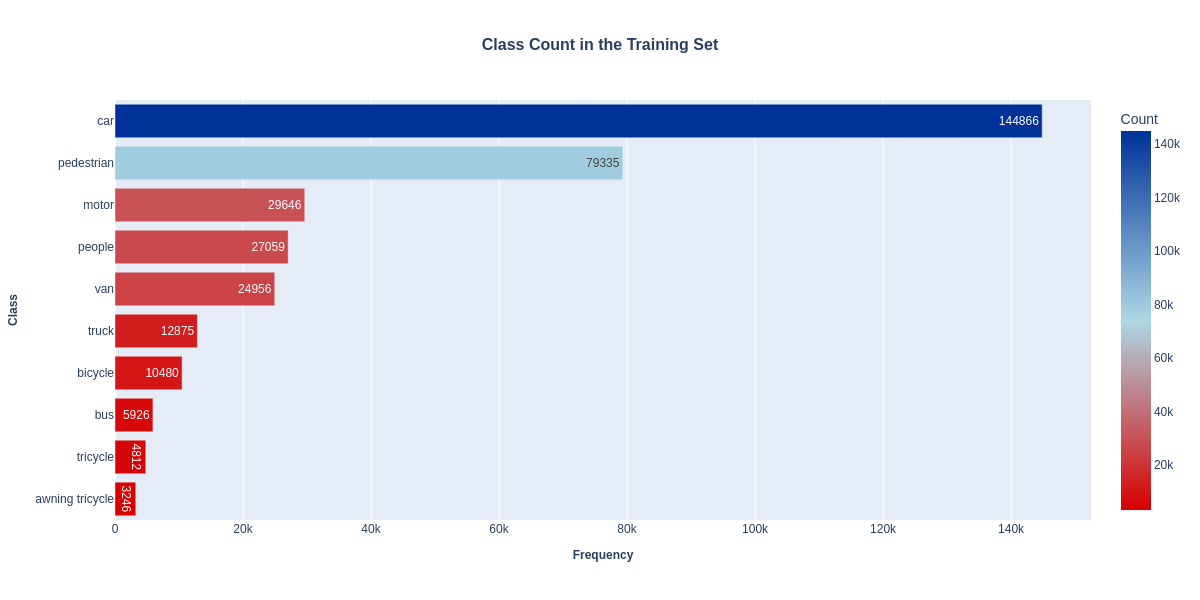

In [ ]:
#plot_counts(num_train_instances) In this case, it is not strictly necessary to create interactive graphs
plot_counts(num_train_instances, renderer="png")

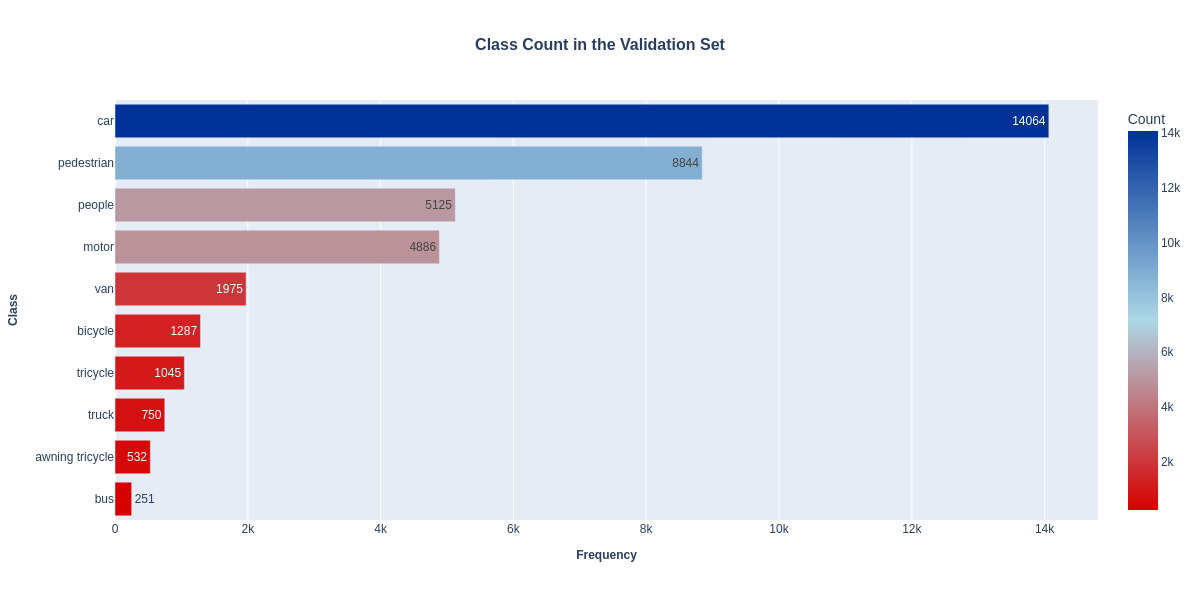

In [ ]:
#plot_counts(num_val_instances, split="validation")
plot_counts(num_val_instances, split="validation", renderer="png")

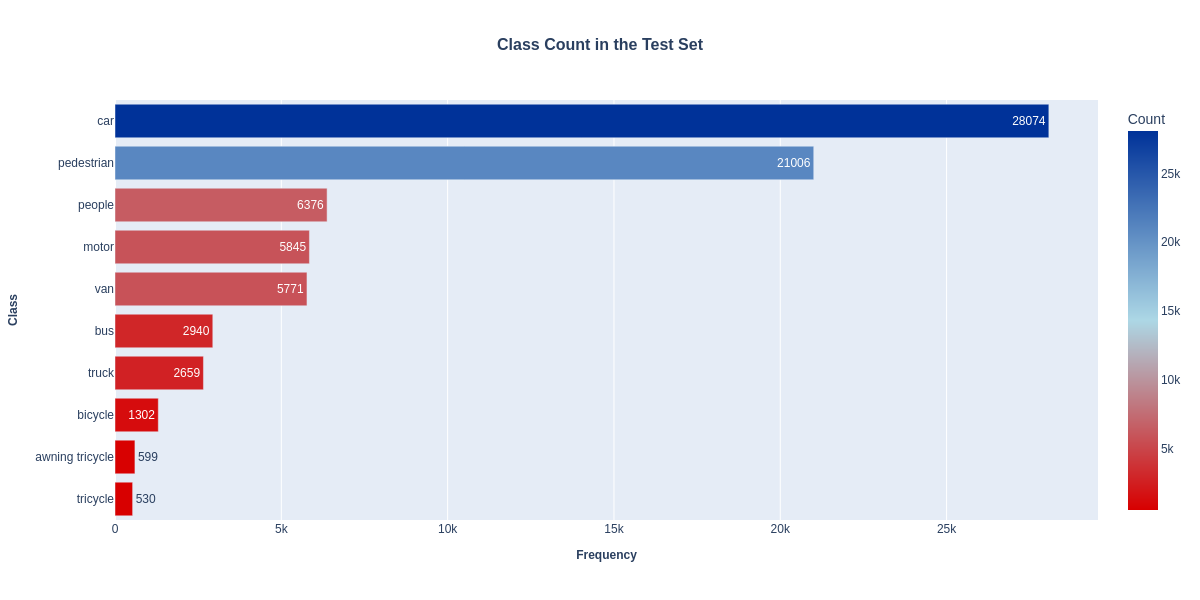

In [ ]:
#plot_counts(num_test_instances, split="test")
plot_counts(num_test_instances, split="test", renderer="png")

In [ ]:
# Create a DataFrame containing the most important metrics
df_instances = pd.DataFrame({
    "Class": class_names,
    "TrainCount": num_train_instances.Count,
    "ValCount": num_val_instances.Count,
    "TestCount": num_test_instances.Count,
    "TotalCount": num_train_instances.Count + num_val_instances.Count + num_test_instances.Count,
    "TrainRatio": (num_train_instances.Count / (num_train_instances.Count + num_val_instances.Count + num_test_instances.Count)) * 100,
    "ValRatio": (num_val_instances.Count / (num_train_instances.Count + num_val_instances.Count + num_test_instances.Count)) * 100,
    "TestRatio": (num_test_instances.Count / (num_train_instances.Count + num_val_instances.Count + num_test_instances.Count)) * 100
})

df_instances.sort_values(by="ValRatio", ascending=False)

,Class,TrainCount,ValCount,TestCount,TotalCount,TrainRatio,ValRatio,TestRatio
6,tricycle,4812,1045,530,6387,75.340535,16.361359,8.298106
1,people,27059,5125,6376,38560,70.173755,13.290975,16.535270
7,awning tricycle,3246,532,599,4377,74.160384,12.154444,13.685172
9,motor,29646,4886,5845,40377,73.422988,12.100949,14.476063
2,bicycle,10480,1287,1302,13069,80.189762,9.847731,9.962507
0,pedestrian,79335,8844,21006,109185,72.661080,8.100014,19.238906
3,car,144866,14064,28074,187004,77.466792,7.520695,15.012513
4,van,24956,1975,5771,32702,76.313375,6.039386,17.647239
5,truck,12875,750,2659,16284,79.065340,4.605748,16.328912
8,bus,5926,251,2940,9117,64.999452,2.753099,32.247450


It can be observed that the three datasets are not balanced regarding the number of instances per class. The majority classes are ``car`` and ``pedestrian``, while the minority classes are ``awning tricycle``, ``tricycle``, and ``bus``. If a **YOLO11** model from Ultralytics is fine-tuned with this dataset, the class imbalance should not pose a significant issue, as the **Distribution Focal Loss (DFL)** helps to mitigate this problem. Additionally, it is noted that in the training dataset, the percentage of instances relative to the total is approximately equal, whereas in the validation and test datasets, it varies. Therefore, the model's performance during evaluation may fluctuate depending on which classes have the highest number of instances in each respective dataset.